# Adversarial samples (smallNORB)

**Author**: Maleakhi A. Wijaya  
**Description**:  
We attack the original smallNORB dataset using adversarial shifts and visualise the results in this notebook.

In [1]:
# Load utilities functions
%run ../../scripts/smallnorb_utils.py
%run ../../scripts/fgsm_adversarial.py

In [2]:
## Random seed
SEED = 20
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load dataset and model

This section loads subset of dSprites data and the end-to-end model that we will attack.

In [3]:
files_dir = "../../data"
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split_smallnorb(files_dir, DatasetTask.Task1, 
                                                                               train_size=0.75, class_index=0,
                                                                              resize_size=64)

Training samples: 36450
Testing samples: 12150


In [4]:
# Split into training, validation, and test
X_valid, X_train = X_train[:10000], X_train[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]
c_valid, c_train = c_train[:10000], c_train[10000:]

# Useful params
orig_dims = X_test.shape[1:]
labels = ["four-legged animals", "human figures", "airplanes", "trucks", "cars"]

In [5]:
# Load model
model_path = "../../models/end_to_end_smallnorb_task1"
end_to_end_model = tf.keras.models.load_model(model_path)

## FGSM

In this section, we fool the model and attack the test dataset using the FGSM adversarial. We store the resulting image in the repository (under data > adversarial_samples).

In [11]:
generate_adversarials(X_test, y_test, end_to_end_model, "smallnorb", False, 
                      epsilon=0.1, n_plots=0, save=True)

100%|██████████| 15000/15000 [01:12<00:00, 207.23it/s]


### Visualisation
We load and visualise the adversarial patterns and the resulting adversarial images.

In [6]:
## Load adversarial images
X_adversarial = np.load("../../data/adversarial_samples/X_adversarial_smallnorb.npy")
perturb = np.load("../../data/adversarial_samples/perturbations_smallnorb.npy")

## Reshape
X_adversarial_orig = X_adversarial.reshape((-1, 64, 64, 1)) # reshape into original dimensions
perturb_orig = perturb.reshape((-1, 64, 64, 1)) # reshape into original dimensions

/auto/homes/maw219/explaining-dataset-shifts/scripts/data_utils.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 4))


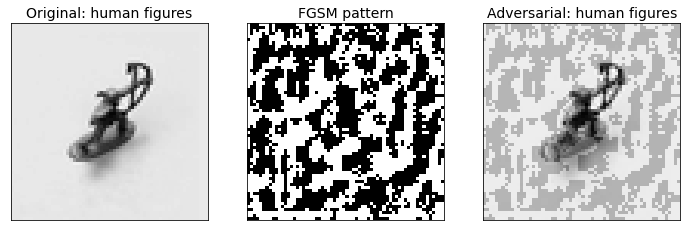

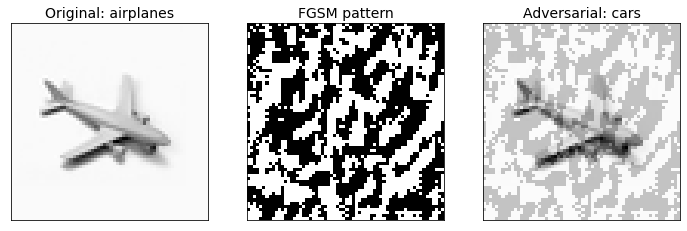

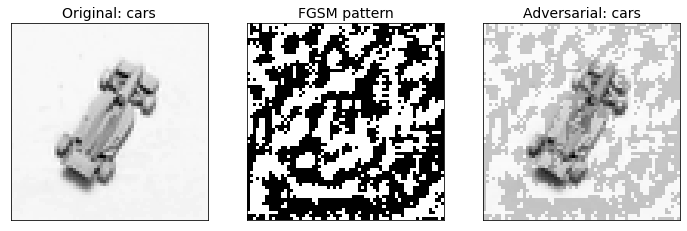

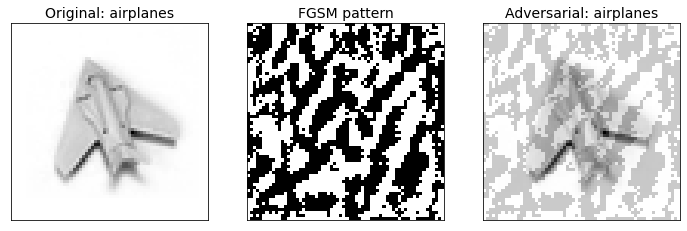

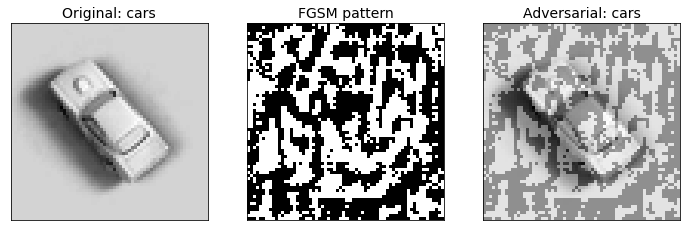

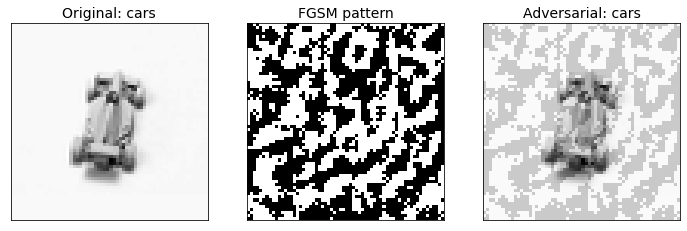

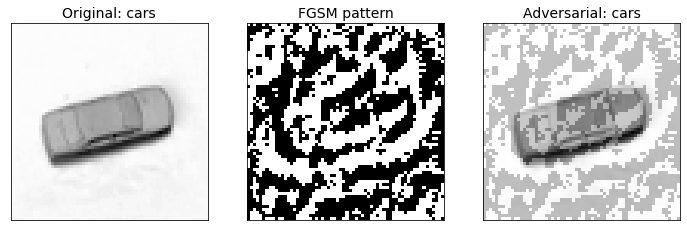

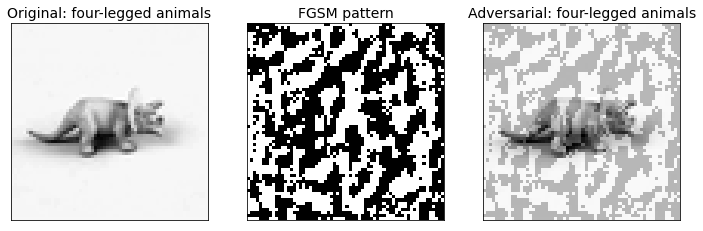

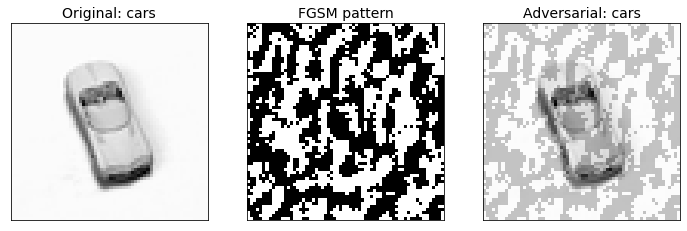

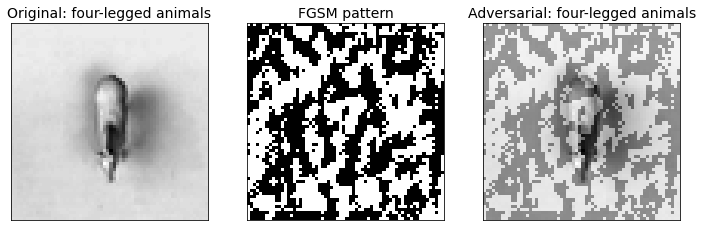

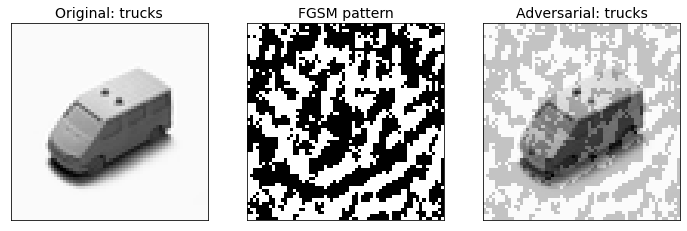

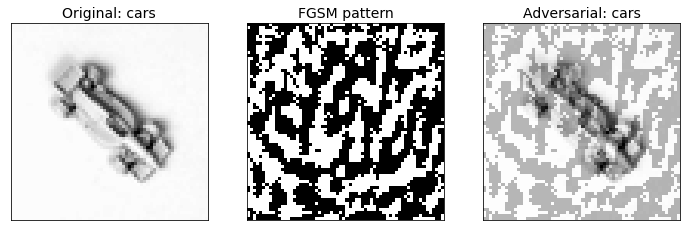

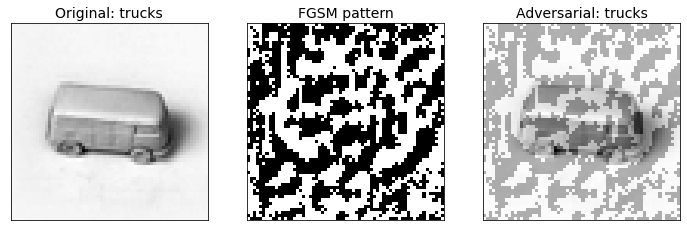

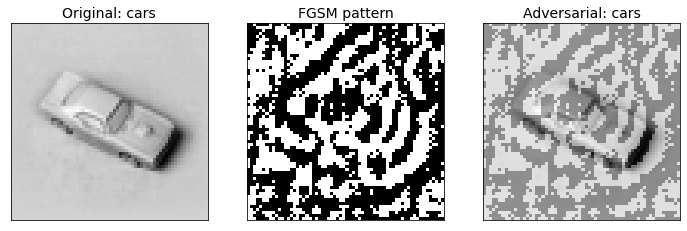

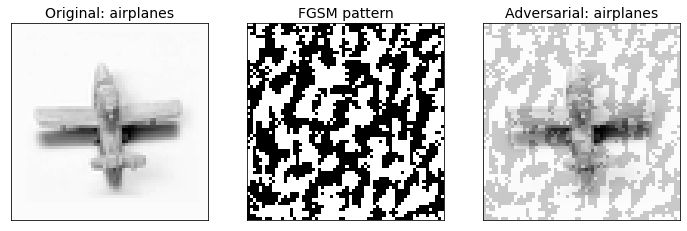

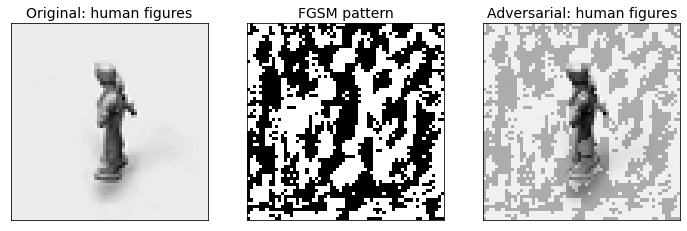

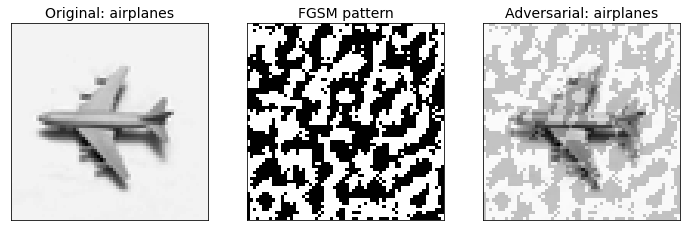

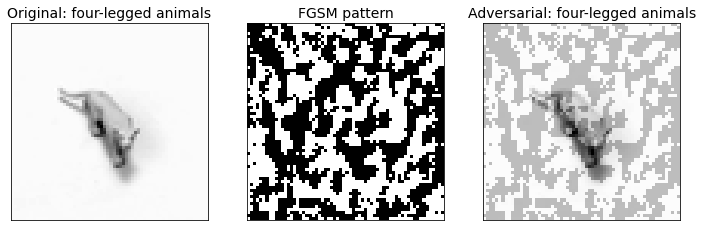

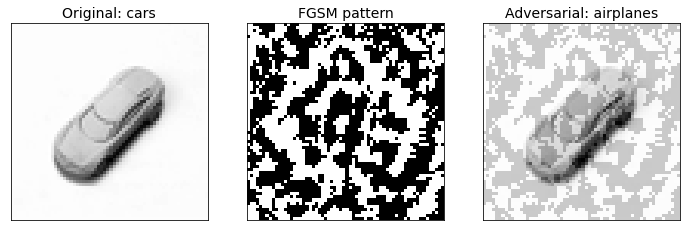

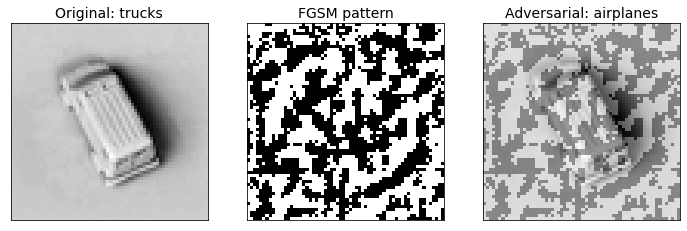

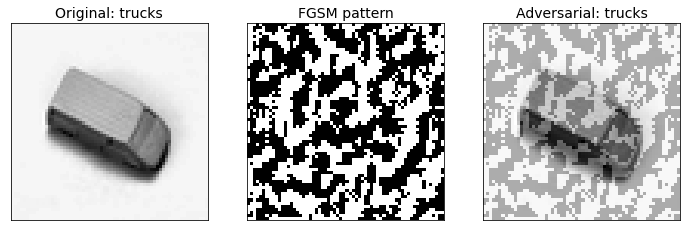

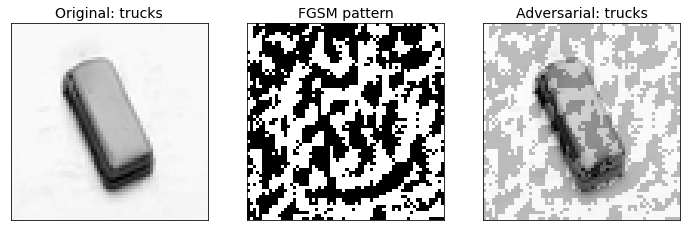

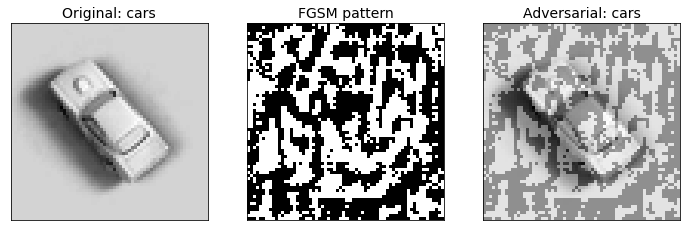

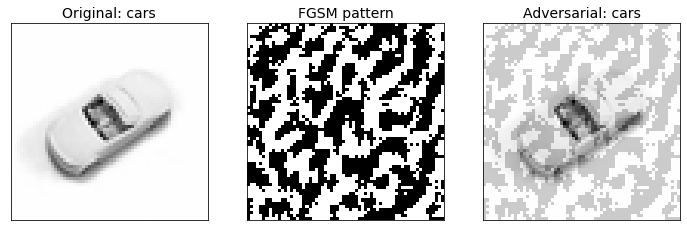

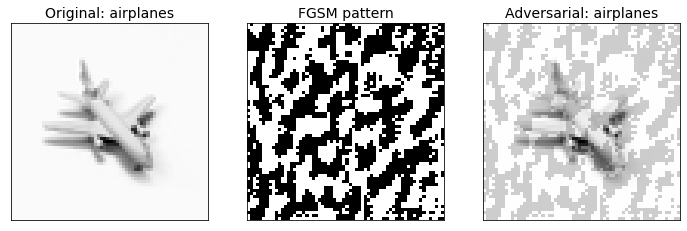

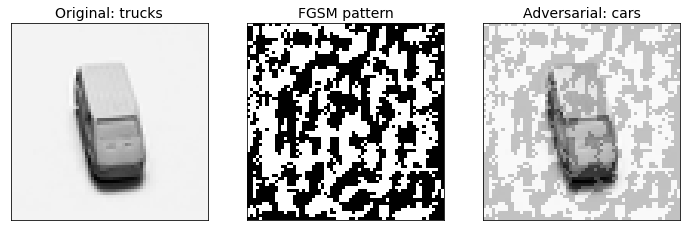

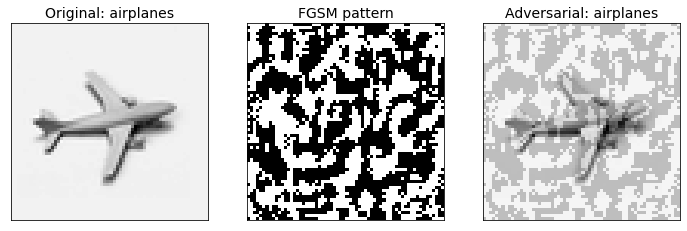

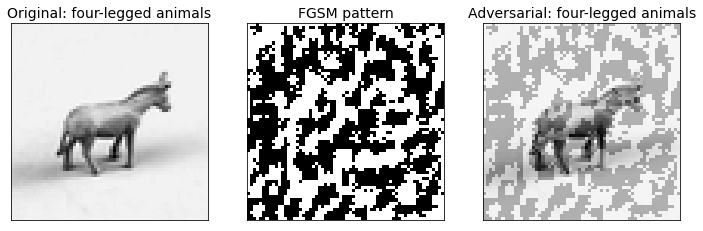

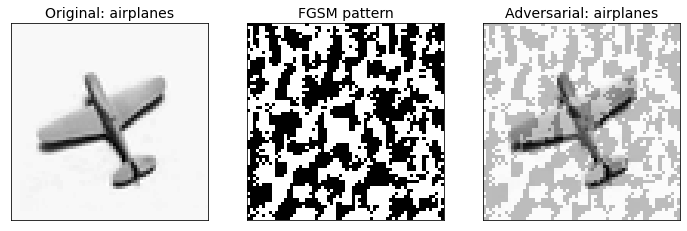

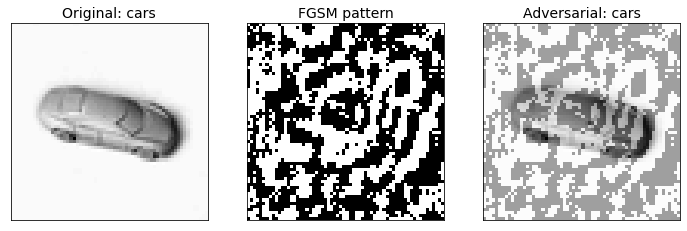

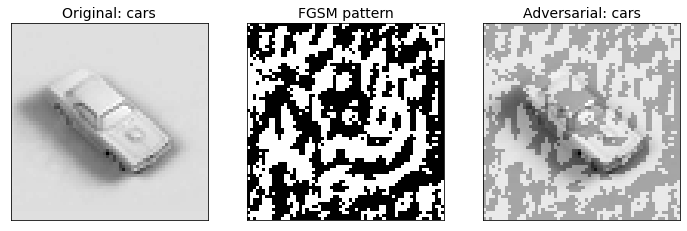

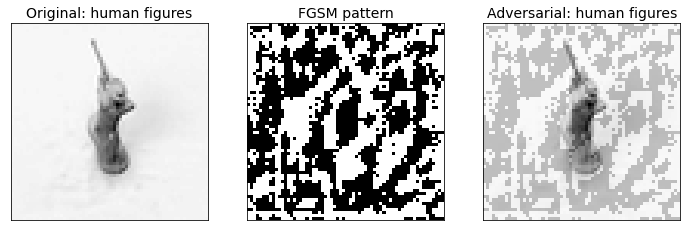

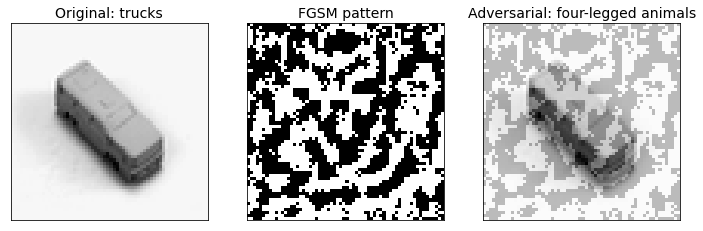

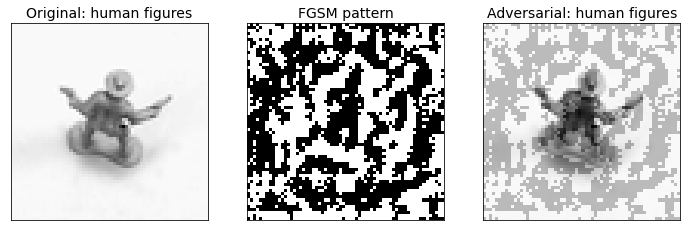

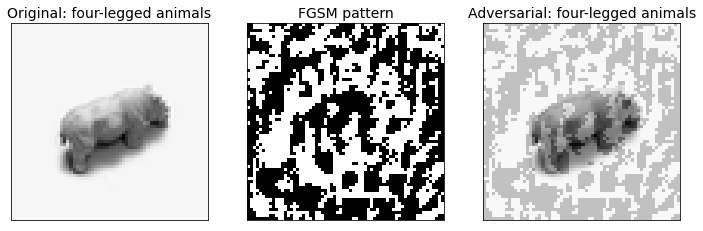

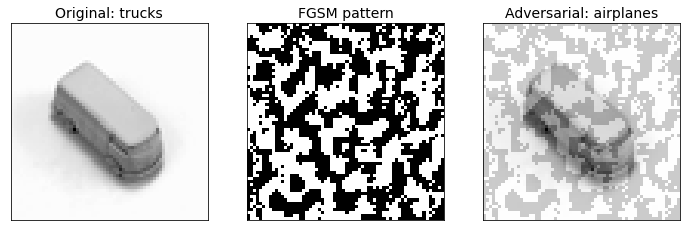

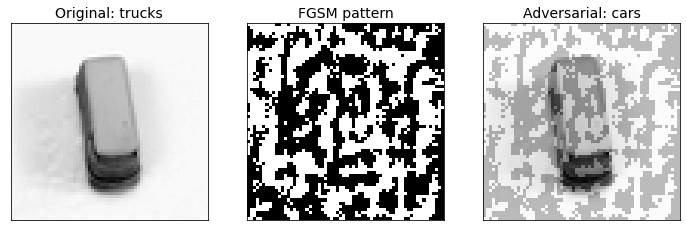

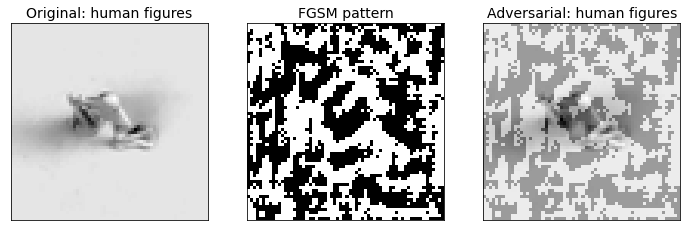

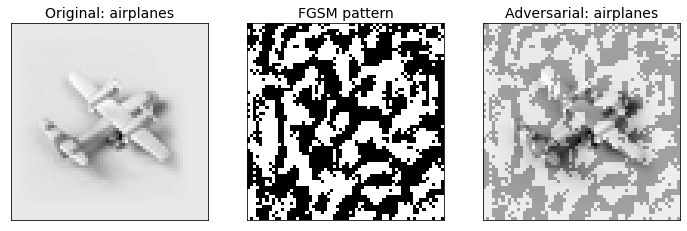

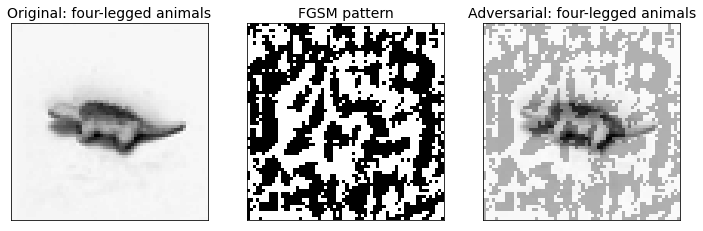

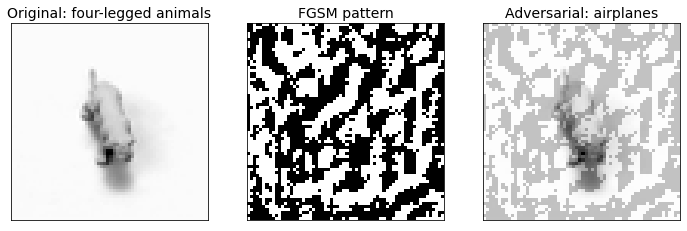

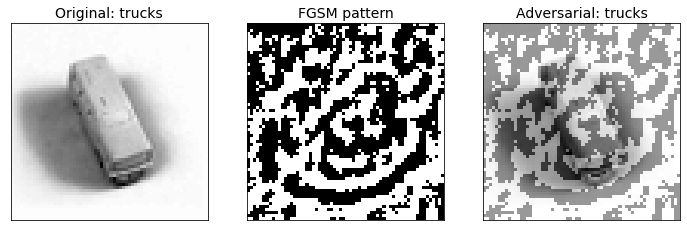

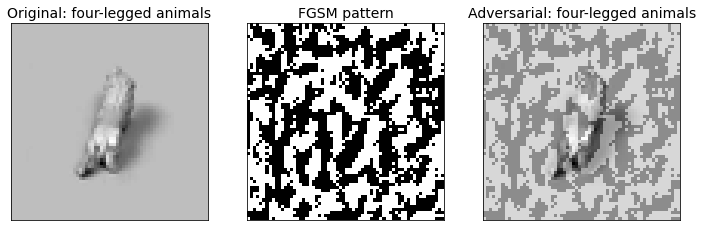

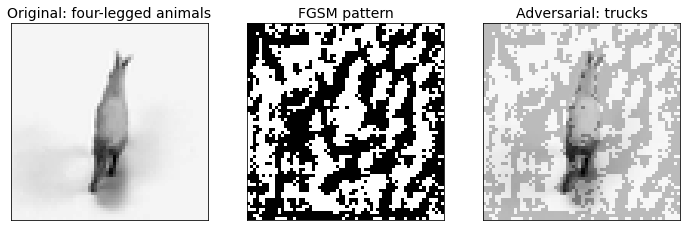

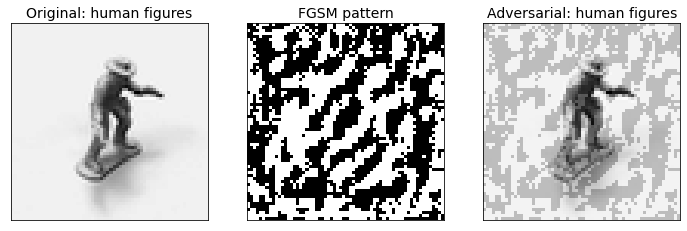

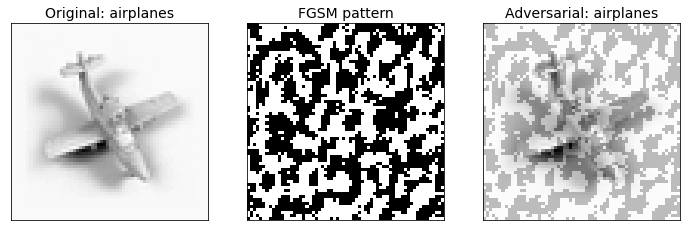

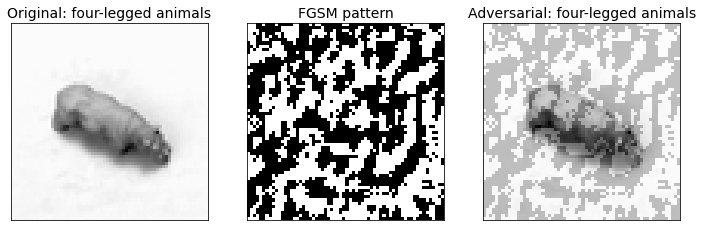

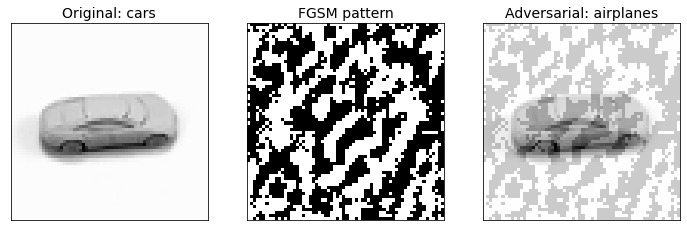

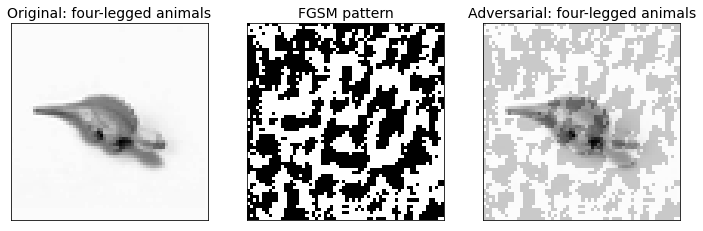

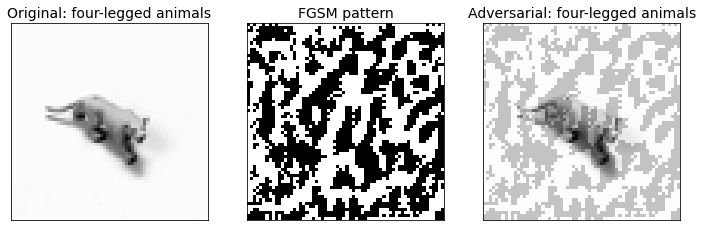

In [7]:
visualise_adversarial(X_test, perturb_orig, X_adversarial_orig, orig_dims,
                      end_to_end_model, labels, n_plots=50)

### Evaluation 

We calculate the before and after accuracy for the end-to-end and multitask models.

#### End-to-end model

**Before**

In [8]:
# Evaluate model (after)
y_pred = end_to_end_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2426
           1       1.00      1.00      1.00      2439
           2       1.00      1.00      1.00      2429
           3       1.00      1.00      1.00      2426
           4       1.00      1.00      1.00      2430

    accuracy                           1.00     12150
   macro avg       1.00      1.00      1.00     12150
weighted avg       1.00      1.00      1.00     12150



**After**

In [9]:
# Evaluate model (after)
y_pred = end_to_end_model.predict(X_adversarial_orig)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      2426
           1       0.97      1.00      0.98      2439
           2       0.69      0.86      0.76      2429
           3       0.81      0.52      0.63      2426
           4       0.58      0.73      0.65      2430

    accuracy                           0.76     12150
   macro avg       0.78      0.76      0.76     12150
weighted avg       0.78      0.76      0.76     12150



#### Multitask model

In [10]:
path = "../../models/multitask_smallnorb"
mt_model = tf.keras.models.load_model(path)

**Before**

In [11]:
# Evaluate model
for i, pred in enumerate(mt_model.predict(X_test)):
    print("*"*20, f"Model: {DSPRITES_CONCEPT_NAMES[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(pred, axis=1)
    
    print(classification_report(c_truth, c_pred))
    print("\n\n")

******************** Model: color ********************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2426
           1       1.00      1.00      1.00      2439
           2       1.00      1.00      1.00      2429
           3       1.00      1.00      1.00      2426
           4       1.00      1.00      1.00      2430

    accuracy                           1.00     12150
   macro avg       1.00      1.00      1.00     12150
weighted avg       1.00      1.00      1.00     12150




******************** Model: shape ********************
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1263
           1       0.90      0.86      0.88      1209
           2       0.90      0.91      0.91      1167
           3       0.89      0.87      0.88      1197
           4       0.90      0.89      0.89      1210
           5       0.92      0.87      0.89      1261
           6       

**After**

In [12]:
# Evaluate model
for i, pred in enumerate(mt_model.predict(X_adversarial_orig)):
    print("*"*20, f"Model: {DSPRITES_CONCEPT_NAMES[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(pred, axis=1)
    
    print(classification_report(c_truth, c_pred))
    print("\n\n")

******************** Model: color ********************
              precision    recall  f1-score   support

           0       0.88      0.39      0.54      2426
           1       0.97      0.96      0.96      2439
           2       0.51      0.94      0.66      2429
           3       0.84      0.40      0.55      2426
           4       0.59      0.74      0.65      2430

    accuracy                           0.69     12150
   macro avg       0.76      0.68      0.67     12150
weighted avg       0.76      0.69      0.67     12150




******************** Model: shape ********************
              precision    recall  f1-score   support

           0       0.38      0.38      0.38      1263
           1       0.34      0.38      0.36      1209
           2       0.39      0.58      0.47      1167
           3       0.49      0.21      0.29      1197
           4       0.29      0.53      0.38      1210
           5       0.50      0.33      0.39      1261
           6       